## 03/20/23

* Notes from meeting:

- See if I can isolate the false negatives and false positives.
- Increase more real high-z in training sample to see if it helps.
- Check if redshift is higher side (above 3.2) be cautious about edge.
- Cut more of left side. 

Why exactly is it helpful for an algorithm to be able to classify high-z sources from their spectra?
Ultimately science goal to use high-z to constrain cosmological parameters. How accurately we can constrain depends on . The better we can measure Ly-a the better the cosmological parameters. Increasing data volume. Finding high-z in an automated way, for HETDEX goals. 


# Notes:

Maybe normalize data? Look into it! Could standardized spectrum. Test!

Maybe change pLya to 9?

Get more spectra from any field for training purposes. Data.


http://ned.ipac.caltech.edu/level5/March19/Baron/Baron2.html

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [46]:
# Using this to be able to plot spectra. For some reason Jupyter won't let me plot spectra without this
%matplotlib inline

## Create our own labels:
    - Random empty spot as noise
    
## Use entire spectrum and not encoded.

* Extracted entire noise spectrum. 

* Combine the high confidence and noise array. Here are the labels for it. 

### Ultimately, we want the ML algorithm to be able to pick out high-z sources from noise!

In [3]:
# loading in the decoded sources I got from inputting random encoded sources into t-sne.
# These will be our testing sample
random_highz_sources = np.load("highz_sources.npy")

In [4]:
# loading in my high confidence high z sources.
high_confidence_highz_spectra = np.load("high_confidence_highz_10000.npy", allow_pickle = True)

In [5]:
# loading in the noise sample.
noise_sample = np.load("noise_sample_10000.npy", allow_pickle = True)

In [6]:
high_confidence_highz_spectra.shape

(10000, 1036)

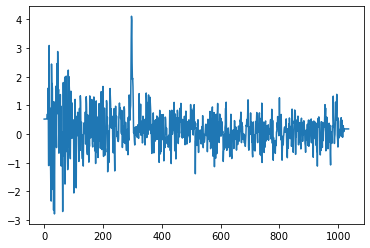

In [7]:
plt.plot(high_confidence_highz_spectra[6])

In [8]:
noise_sample.shape

(10000, 1036)

In [125]:
high_confidence_highz_spectra[0].shape

(1036,)

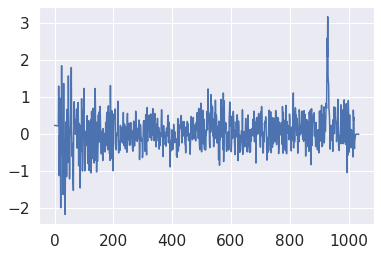

In [136]:
plt.plot(high_confidence_highz_spectra[0])

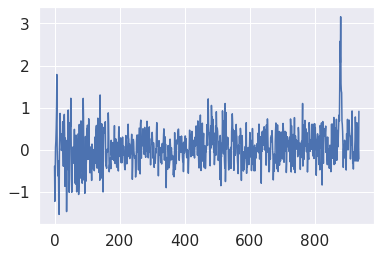

In [135]:
plt.plot(high_confidence_highz_spectra[0][50:(len(high_confidence_highz_spectra[0])) - 50])

In [238]:
slice_amount = 0
num_sources = high_confidence_highz_spectra.shape[0]
#num_sources = 5
sliced_highz_ls = [[0] * 1 for i in range(num_sources)]
sliced_noise_ls = sliced_highz_ls

counter = 0
while counter < num_sources:
    sliced_highz_ls[counter] = high_confidence_highz_spectra[counter, slice_amount:len(high_confidence_highz_spectra[counter]) - slice_amount]
    sliced_noise_ls[counter] = noise_sample[counter, slice_amount:len(noise_sample[counter]) - slice_amount]
    
    counter += 1
    

In [239]:
sliced_highz = np.array(sliced_highz_ls)
sliced_noise = np.array(sliced_noise_ls)

In [240]:
sliced_highz.shape

(10000, 1036)

In [241]:
sliced_noise.shape

(10000, 1036)

In [ ]:
from sklearn import preprocessing

In [ ]:
normalized_highz = preprocessing.normalize(high_confidence_highz_spectra)

In [ ]:
normalized_noise = preprocessing.normalize(noise_sample)

## Random-Forest classification

https://levelup.gitconnected.com/random-forest-regression-209c0f354c84#:~:text=Random%20Forest%20Regression%20is%20a%20supervised%20learning%20algorithm%20that%20uses,prediction%20than%20a%20single%20model.

https://www.datacamp.com/tutorial/random-forests-classifier-python

## According to internet, issues with overfitting! Possibly need more data.

https://stackoverflow.com/questions/62445343/randomforestregressor-in-sklearn-giving-negative-scores

In [242]:
twodspectra = np.concatenate((sliced_highz, sliced_noise))
#twodspectra = np.concatenate((high_confidence_highz_spectra, noise_sample))
#twodspectra = np.concatenate((normalized_highz, normalized_noise))

In [243]:
highz_classification = np.ones(10000)
noise_classification = np.zeros(10000)

merge_classification = np.append(highz_classification, noise_classification)

### Make my own labels:
https://towardsdatascience.com/labeling-data-with-pandas-9e573ce59c42

In [244]:
X = twodspectra
y = merge_classification

In [245]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [246]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

### Note on number of estimators/trees
- The more trees you have the more accurate the model will be, however it only helps a certain amount. I started with 100 estimators (and no changing of any parameters) and got an accuracy of around ~67-69%, I then increased to 500 estimators and got ~70-71% and then I went to 1000 estimators and it stayed the same as with 500 estimators. I even went to 10,000 and it stayed the same (might have even gone lower) as with 1000 estimators. Also takes awhile to run with 10,000. If anything 500 might have better accuracy.

In [247]:
# creating a RF classifier
rfc = RandomForestClassifier(n_estimators = 700, random_state = 42)  

In [ ]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rfc.fit(X_train, y_train)

In [ ]:
# performing predictions on the test dataset
y_pred = rfc.predict(X_test)

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

In [80]:
# View confusion matrix for test data and predictions
#metrics.confusion_matrix(y_test, y_pred)

In [204]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred, normalize = 'true').ravel()

In [205]:
(tn, fp, fn, tp)

(0.16895742541066042,
 0.8310425745893396,
 0.8614517732847199,
 0.13854822671528008)

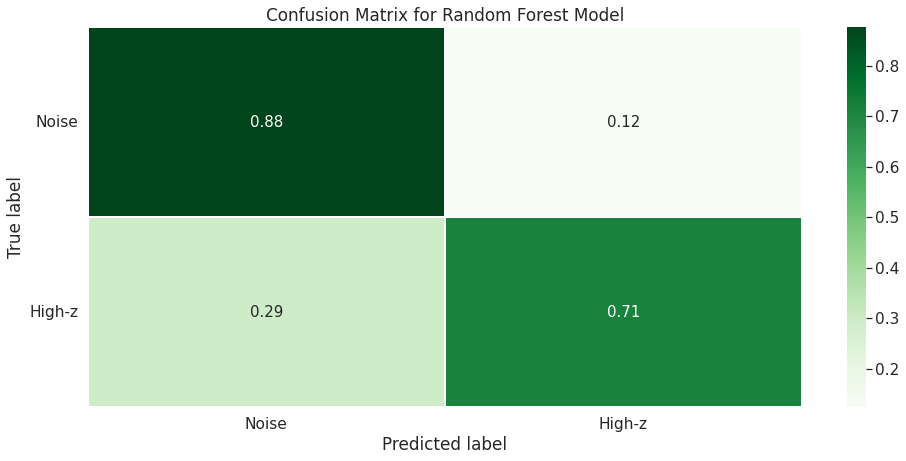

In [105]:
# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Noise', 'High-z']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names, rotation= 0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [96]:
# metrics are used to find accuracy or error 
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.7953333333333333


In [23]:
from sklearn.model_selection import GridSearchCV

In [31]:
param_grid = { 
    'n_estimators': [2000, 5000, 10000],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [None, 100, 1000],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring = 'accuracy', cv= 5)
CV_rfc.fit(X_train, y_train)

In [36]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 10000}

In [41]:
# creating a RF classifier
rfc2 = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', max_depth = None, \
                              max_features = 'sqrt', random_state = 42)  

In [42]:
rfc2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [43]:
y_pred = rfc2.predict(X_test)

In [44]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.8003333333333333
Precision: 0.8622062923138192
Recall: 0.7176002651640703


In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

In [ ]:
clf.predict(X_test[0].reshape(1, -1))

In [ ]:
clf.predict(X_test[1].reshape(1, -1))

In [ ]:
y_test[0]

In [ ]:
y_test[1]

In [ ]:
plt.plot(X_test[0])

In [ ]:
plt.plot(X_test[1])

Idk how much this would help but i recall that certain algorithms do better when the data is normalized. Maybe we can try implementing that and see how it does.
I think sklearn has some standard scaler that normalizes the data in a way to be used for ML purposes
white_check_mark
eyes
raised_hands





11:14
We can also look into the documentations and see what parameters we think has a big impact on the classification
11:15
and tweak those one at a time to see which has the biggest impact

In [ ]:
from sklearn import tree
import dtreeviz # will be used for tree visualization

In [ ]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(clf.estimators_[0], feature_names=X, filled=True)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf.fit(X, y)

In [ ]:
plt.figure(figsize=(18,18))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X, filled=True, fontsize = 10)

In [ ]:
viz = dtreeviz.model(rf.estimators_[0], X, y, feature_names=X, target_name="Target")

In [ ]:
viz.view() 

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0],
          class_names=["highz", "noise"], 
          filled=True, impurity=True, 
          rounded=True)

In [ ]:
plt.plot(X[42])

In [ ]:
plt.plot(X[984])

## Plotting
https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f 

https://builtin.com/data-science/random-forest-python-deep-dive

https://vitalflux.com/random-forest-classifier-python-code-example/

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

#GRIDSEARCHCV
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Different models

In [69]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.516
Precision: 0.5081521739130435
Recall: 0.9973333333333333


In [70]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.5543333333333333
Precision: 0.6299840510366826
Recall: 0.2633333333333333


In [71]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.5261666666666667
Precision: 0.5135977827819158
Recall: 0.9883333333333333


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

# Article for data prep
https://www.analyticsvidhya.com/blog/2021/06/4-ways-to-handle-insufficient-data-in-machine-learning/

### 03/01/23

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
https://www.keboola.com/blog/random-forest-regression#:~:text=If%20you%20want%20to%20increase,the%20maximum%20number%20of%20features.
https://www.kaggle.com/questions-and-answers/261231
https://www.kdnuggets.com/2018/12/feature-engineering-explained.html#:~:text=Feature%20Engineering%20Example%3A%20Continuous%20data,some%20object%20on%20the%20map.
https://www.analyticsvidhya.com/blog/2021/06/4-ways-to-handle-insufficient-data-in-machine-learning/
https://opg.optica.org/ol/fulltext.cfm?uri=ol-44-23-5864&id=423702
https://opg.optica.org/view_article.cfm?pdfKey=eb0ab124-2dbd-48bc-a1ae9c5771f8fea1_423702
https://www.nature.com/articles/s41467-021-21481-0
https://www.aanda.org/articles/aa/full_html/2016/07/aa28660-16/aa28660-16.html
https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501